In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

device = 'cuda:2'

In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# data_path="/root/data/ILSVRC2012_val/"

# _, valid_datasets = get_datasets("imagenet1k", data_path)
# valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# eval_mode = model.eval()

In [4]:
# # n02443484: 40 black-footed_ferret
# # n01614925: 398 bald_eagle

# data_path="/root/data/ILSVRC2012_val/"

# ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
# ferrot_idx = os.listdir(ferrot_dir)[1]
# ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
# ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# # eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# # eagle_idx = os.listdir(eagle_dir)[1]
# # eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# # eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [3]:
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/data8/donghun/cifar10/untracked/', train=False, transform=transform)
# valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
# interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

In [4]:
# interpolation.shape
model = torch.load("/data8/donghun/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to(device)
# model = torch.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')


/home/dhlee/anaconda3/envs/dh1/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [14]:
# from ig_pkg.utils.attribution import integrated_gradient

# attribution = []
# for i in range(len(valid_dataset)):
#     label = valid_dataset[i][1]
#     interp = interpolation[i].to('cuda:0')
#     input = interp[0].to('cuda:0')
#     baseline = interp[-1].to('cuda:0')
    
#     attrib = integrated_gradient(model, input, label, baseline, interp, 'cuda:0') # tensor
    
#     attribution.append(attrib.detach().cpu())
# attribution = torch.stack(attribution)
# attribution.shape
# np.save("/root/results/cifar10/image_simple_gradient_ascent_attribution.npy", attribution.numpy())

PGD 

In [15]:
import torch
import torch.nn as nn

from ..attack import Attack


class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + \
                torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images,
                                min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

torch.Size([10000, 32, 32])

In [5]:
def logit(model, image, label):
    temp = image.unsqueeze(0).clone().detach()
    logit = model(temp)
    return logit

def score(model, image, label):
    temp = image.unsqueeze(0).clone().detach()
    logit = model(temp)
    score = torch.softmax(logit, dim = -1)
    sc = score[0, label].item()
    return sc

In [ ]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=24, device='cuda:0'):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data

    # interp = [images]
    # st = time.time()
    sc = []
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        # print(time.time() - st)
        # print(score(model, images.squeeze(0), labels))
        sc.append(score(model, images.squeeze(0), labels))
        # interp.append(images)
    return sum(sc)/iters

for i in range(100):
    adver = pgd_attack(model, valid_dataset[i][0].unsqueeze(0), torch.tensor([valid_dataset[i][1]]), eps=0.3, alpha=2/255, iters=10, device='cuda:0')
    print(adver)

In [16]:
def pgd_attack1(model, images, device, labels, eps=0.3, alpha=2/255, iters=24):
    interp = [images]

    images = images.unsqueeze(0).to(device)
    labels = torch.tensor([labels]).to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data

    
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        
        interp.append(images.squeeze(0).clone().detach().cpu())
    print(1)
    interp = torch.stack(interp)
    return interp

In [18]:
# from ig_pkg.utils.adversarial import pgd_attack
# # print(valid_dataset[10][1])
adver = pgd_attack1(model, valid_dataset[10][0], 'cuda:0', valid_dataset[10][1], eps=0.3, alpha=2/255, iters=24)

adver.shape

1


torch.Size([25, 3, 32, 32])

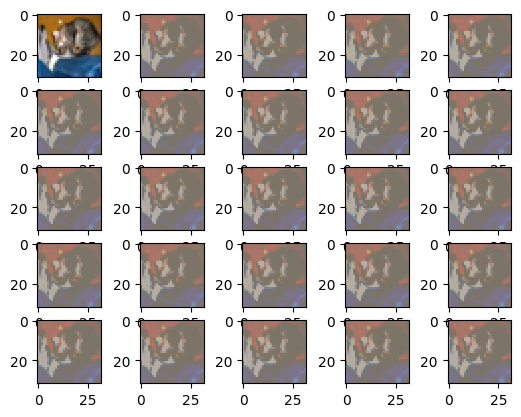

In [31]:
# adver = torch.stack(adver)
# adver.shape

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(25):
    temp = adver[i]
    ax = next(axes_flat)
    ax.imshow(convert_to_img(temp.squeeze(0)))

In [23]:
import time
device = "cuda:0"
image = valid_dataset[0][0].detach().clone().to(device)
label = valid_dataset[0][1]

loss = nn.CrossEntropyLoss()
alpha = 2/225
eps = 8/225

adv_image = image.clone().detach()
adv = [adv_image]
st = time.time()
for _ in range(24):
    adv_image.requires_grad = True
    outputs = logit(model, adv_image, label)

    cost = loss(outputs, torch.tensor([label]).to(device))

    # Update adversarial images
    grad = torch.autograd.grad(cost, adv_image, retain_graph=False, create_graph=False)[0]

    adv_image = adv_image.detach() + alpha*grad.sign()
    
    delta = torch.clamp(adv_image - image, min=-eps, max=eps)
    
    adv_image = torch.clamp(image + delta, min=0, max=1).detach()
    adv.append(adv_image)
    print(score(model, adv_image.to(device), label))    
    print(time.time() - st)
    
    break

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [16]:
images = images.clone().detach().to(self.device)
labels = labels.clone().detach().to(self.device)

loss = nn.CrossEntropyLoss()
adv_images = images.clone().detach()

for _ in range(self.steps):
    adv_images.requires_grad = True
    outputs = self.get_logits(adv_images)

    # Calculate loss
    if self.targeted:
        cost = -loss(outputs, target_labels)
    else:
        cost = loss(outputs, labels)

    # Update adversarial images
    grad = torch.autograd.grad(cost, adv_images,
                                retain_graph=False, create_graph=False)[0]

    adv_images = adv_images.detach() + self.alpha*grad.sign()
    delta = torch.clamp(adv_images - images,
                        min=-self.eps, max=self.eps)
    adv_images = torch.clamp(images + delta, min=0, max=1).detach()

In [18]:
model.device

AttributeError: 'RecursiveScriptModule' object has no attribute 'device'

C-W attack

In [16]:
def logit(model, image, label):
    temp = image.clone().detach()
    logit = model(temp)
    return logit

def score(model, image, label):
    temp = image.unsqueeze(0).clone().detach()
    logit = model(temp)
    score = torch.softmax(logit, dim = -1)
    sc = score[0, label].item()
    return sc

def inverse_tanh_space(x):
    temp = torch.clamp(x*2-1, min=-1, max=1)
    atanh = 0.5*torch.log((1+temp)/(1-temp))
    return atanh

# f-function in the paper
def f(outputs, labels, kappa):
    one_hot_labels = torch.eye(outputs.shape[1]).to(device)[labels]

    # find the max logit other than the target class
    other = torch.max((1-one_hot_labels)*outputs, dim=1)[0]
    # get the target class's logit
    real = torch.max(one_hot_labels*outputs, dim=1)[0]

    return torch.clamp((real-other), min=-kappa)

def cw_attack(model, image, label, device, iter, c=1, kappa=0, lr=0.01):
    model = model.to(device)
    interp = [image.clone().detach().cpu()]
    
    images = image.unsqueeze(0).clone().detach().to(device) # 1, 3, 32, 32
    labels = torch.tensor([label]).clone().detach().to(device)

    w = inverse_tanh_space(images).detach()
    w.requires_grad = True

    best_adv_images = images.clone().detach()
    best_L2 = 1e10*torch.ones((len(images))).to(device)
    prev_cost = 1e10
    dim = len(images.shape)

    MSELoss = nn.MSELoss(reduction='none')
    Flatten = nn.Flatten()

    optimizer = optim.Adam([w], lr=lr)
    print(w)
    for step in range(iter):
        # Get adversarial images
        adv_images = 1/2*(torch.tanh(w) + 1)
        adv_images = adv_images.to(device)
        
        # Calculate loss
        current_L2 = MSELoss(Flatten(adv_images),
                                Flatten(images)).sum(dim=1)
        L2_loss = current_L2.sum()

        outputs = model(adv_images)
        
        f_loss = f(outputs, labels, kappa).sum()

        cost = L2_loss + c*f_loss

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Update adversarial images
        pre = torch.argmax(outputs.detach(), 1)

        # If the attack is not targeted we simply make these two values unequal
        condition = (pre != labels).float()

        # Filter out images that get either correct predictions or non-decreasing loss,
        # i.e., only images that are both misclassified and loss-decreasing are left
        mask = condition*(best_L2 > current_L2.detach())
        best_L2 = mask*current_L2.detach() + (1-mask)*best_L2

        mask = mask.view([-1]+[1]*(dim-1))
        best_adv_images = mask*adv_images.detach() + (1-mask)*best_adv_images

        print(torch.softmax(model(best_adv_images.to(device)), dim = -1)[:, label])

        interp.append(best_adv_images.squeeze(0).clone().detach().cpu())
        print(w)
        break

    interp = torch.stack(interp)
    print()
    return interp




In [18]:
for i in range(20):
    cw = cw_attack(model, valid_dataset[i][0], valid_dataset[i][1], device, 24, c=1, kappa=0, lr=0.01)
    break

tensor([[[[ 0.2742,  0.3164,  0.6026,  ..., -0.6136, -2.1482,    -inf],
          [ 0.0349, -0.0039,  0.3164,  ..., -0.6707,    -inf,    -inf],
          [-0.0039, -0.0039,  0.2742,  ..., -0.5089, -1.1509,    -inf],
          ...,
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          ...,
          [-1.9350,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],

         [[   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
          [   -inf,    -inf,  

In [7]:
cw.shape

torch.Size([25, 3, 32, 32])

tensor([0.9983], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.0002], device=

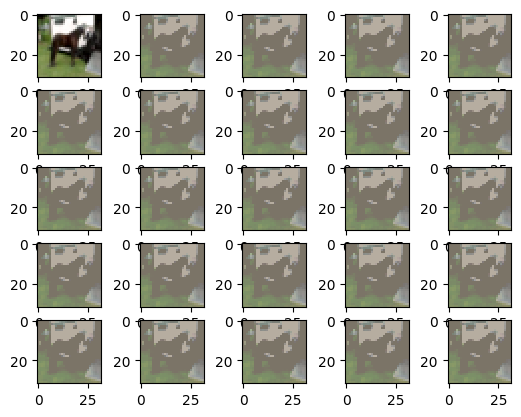

In [12]:
fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(25):
    temp = cw[i]
    ax = next(axes_flat)
    print(torch.softmax(model(temp.unsqueeze(0).to(device)), dim = -1)[:, valid_dataset[20][1]])
    ax.imshow(convert_to_img(temp))

In [35]:
# https://github.com/Harry24k/CW-pytorch/blob/master/CW.ipynb

# CW-L2 Attack
# Based on the paper, i.e. not exact same version of the code on https://github.com/carlini/nn_robust_attacks
# (1) Binary search method for c, (2) Optimization on tanh space, (3) Choosing method best l2 adversaries is NOT IN THIS CODE.
def cw_l2_attack(model, images, labels, device, c=1e-4, kappa=0, iter=24, learning_rate=0.01, ) :
    
    interp =[]

    interp.append(images.cpu())
    images = images.unsqueeze(0).to(device) 
    print(id(images))    
    # labels = torch.tensor([labels]).to(device)
    model.zero_grad()
    
    # Define f-function
    def f(x) :

        outputs = model(x)
        # print(outputs.device)
        # one_hot= torch.eye(len(outputs[0])).to(device)
        # one_hot_labels = one_hot[labels].to(device)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        # j = torch.masked_select(outputs, one_hot_labels.byte())
        
        del one_hot_labels
        return torch.clamp(j-i, min=-kappa, max=kappa)
    
    w = torch.zeros_like(images, requires_grad=True)#.to(device)

    optimizer = optim.Adam([w], lr=learning_rate)
    
    for _ in range(iter) :

        a = 1/2*(nn.Tanh()(w) + 1)
        interp.append(a.squeeze(0).detach().cpu())

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a))
        cost = loss1 + loss2
        # break
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        del a
        
    interp1 = torch.stack(interp)
    del interp
    return interp1

In [18]:
# https://github.com/Harry24k/CW-pytorch/blob/master/CW.ipynb

# CW-L2 Attack
# Based on the paper, i.e. not exact same version of the code on https://github.com/carlini/nn_robust_attacks
# (1) Binary search method for c, (2) Optimization on tanh space, (3) Choosing method best l2 adversaries is NOT IN THIS CODE.
def cw_l2_attack1(model, images, labels, device, c=1e-4, kappa=0, iter=24, learning_rate=0.01, ) :
    
    interp =[images.clone().detach().cpu()]
        
    images = images.unsqueeze(0).to(device) 
    
    w = torch.zeros_like(images, requires_grad=True)#.to(device)

    optimizer = optim.Adam([w], lr=learning_rate)
    
    for _ in range(iter) :

        a = 1/2*(nn.Tanh()(w) + 1)
        interp.append(a.squeeze(0).clone().detach().cpu())

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        
        output = model(a).detach()
        one_hot_label = torch.eye(len(output[0]))[labels].to(device)
        i, _ = torch.max((1-one_hot_label)*output, dim=1)
        j = torch.masked_select(output, one_hot_label.bool())
                
        temp = torch.clamp(j-i, min=-kappa)
        # print(temp)
        
        loss2 = torch.sum(c*temp)
        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    interp1 = torch.stack(interp)
    
    del w, interp, a
    return interp1

In [29]:
ch = []
scc =[]
for i in range(10): #1078
    img, label = valid_dataset[i]
    img = img.to(device)
    intep = cw_l2_attack1(model, img, label, device, c=1e-4, kappa=0, iter=24, learning_rate=0.01)
    ch.append(intep.detach().cpu())
    logit = model(intep.to(device))
    score = torch.softmax(logit, dim=-1)
    sc = torch.mean(score[:, label])
    # print(sc)
    scc.append(sc)
    
# print(sum(ch) / 11)
    

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "<string>", line 176, in <forward op>
                return grad_tensors, None

            return torch.cat(tensors, dim), backward
                   ~~~~~~~~~ <--- HERE

        def index(self,
RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 2; 10.76 GiB total capacity; 9.71 GiB already allocated; 15.44 MiB free; 9.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF



In [28]:
# ch = torch.stack(ch)
# ch.shape
# sum(scc)
del ch

In [8]:
# inte = torch.stack(inte)
inte.shape

torch.Size([25, 3, 32, 32])

tensor([0.9993], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.1700], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.1743], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.1859], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.2124], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.2337], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.2449], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.2701], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.3195], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.3868], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.4954], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.5852], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.6410], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.6814], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.7139], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.7416], device='cuda:2', grad_fn=<SelectBackward0>)
tensor([0.7424], device=

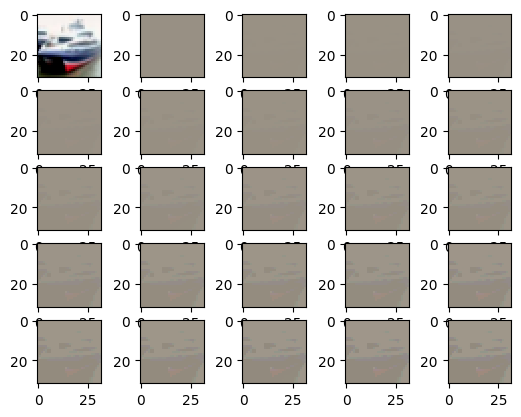

In [26]:
fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))
idx = 1
for i in range(25):
    temp = ch[idx][i]
    ax = next(axes_flat)
    print(torch.softmax(model(temp.unsqueeze(0).to(device)), dim = -1)[:, valid_dataset[idx][1]])
    ax.imshow(convert_to_img(temp))
    

In [ ]:
import operator as op

from typing import Union, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# import runutils

def _var2numpy(var):
    """
    Make Variable to numpy array. No transposition will be made.
    :param var: Variable instance on whatever device
    :type var: Variable
    :return: the corresponding numpy array
    :rtype: np.ndarray
    """
    return var.data.cpu().numpy()


def atanh(x, eps=1e-6):
    """
    The inverse hyperbolic tangent function, missing in pytorch.
    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box):
    # type: (Union[Variable, torch.FloatTensor], Tuple[float, float]) -> Union[Variable, torch.FloatTensor]
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.
    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box):
    # type: (Union[Variable, torch.FloatTensor], Tuple[float, float]) -> Union[Variable, torch.FloatTensor]
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.
    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus

In [ ]:
import operator as op

from typing import Union, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# import runutils

def cw_attack1(model, inputs, targets, to_numpy=True, confidence=0.0, c_range=(1e-3, 1e10),
                search_steps=5, max_steps=1000, abort_early=True,
                box=(-1., 1.), optimizer_lr=1e-2, init_rand=False):

    confidence = float(confidence)
    c_range = (float(c_range[0]), float(c_range[1]))
    binary_search_steps = search_steps
    max_steps = max_steps
    abort_early = abort_early
    ae_tol = 1e-4  # tolerance of early abort
    box = tuple(map(float, box))  # type: Tuple[float, float]
    optimizer_lr = optimizer_lr

    self.init_rand = init_rand

    # Since the larger the `scale_const` is, the more likely a successful
    # attack can be found, `self.repeat` guarantees at least attempt the
    # largest scale_const once. Moreover, since the optimal criterion is the
    # L2 norm of the attack, and the larger `scale_const` is, the larger
    # the L2 norm is, thus less optimal, the last attempt at the largest
    # `scale_const` won't ruin the optimum ever found.
    self.repeat = (self.binary_search_steps >= 10)

def __call__(self, ):
    """
    Produce adversarial examples for ``inputs``.
    :param model: the model to attack
    :type model: nn.Module
    :param inputs: the original images tensor, of dimension [B x C x H x W].
            ``inputs`` can be on either CPU or GPU, but it will eventually be
            moved to the same device as the one the parameters of ``model``
            reside
    :type inputs: torch.FloatTensor
    :param targets: the original image labels, or the attack targets, of
            dimension [B]. If ``self.targeted`` is ``True``, then ``targets``
            is treated as the attack targets, otherwise the labels.
            ``targets`` can be on either CPU or GPU, but it will eventually
            be moved to the same device as the one the parameters of
            ``model`` reside
    :type targets: torch.LongTensor
    :param to_numpy: True to return an `np.ndarray`, otherwise,
            `torch.FloatTensor`
    :type to_numpy: bool
    :return: the adversarial examples on CPU, of dimension [B x C x H x W]
    """

    # get a copy of targets in numpy before moving to GPU, used when doing
    # the binary search on `scale_const`
    targets_np = targets.clone().cpu().numpy()  # type: np.ndarray

    # the type annotations here are used only for type hinting and do
    # not indicate the actual type (cuda or cpu); same applies to all codes
    # below
    inputs = runutils.make_cuda_consistent(model, inputs)[0]  # type: torch.FloatTensor
    targets = runutils.make_cuda_consistent(model, targets)[0]  # type: torch.FloatTensor

    # run the model a little bit to get the `num_classes`
    num_classes = model(Variable(inputs[0][None, :], requires_grad=False)).size(1)  # type: int
    batch_size = inputs.size(0)  # type: int

    # `lower_bounds_np`, `upper_bounds_np` and `scale_consts_np` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds_np < scale_consts_np <= upper_bounds_np
    lower_bounds_np = np.zeros(batch_size)
    upper_bounds_np = np.ones(batch_size) * self.c_range[1]
    scale_consts_np = np.ones(batch_size) * self.c_range[0]

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`: the least L2 norms
    # - `o_best_l2_ppred`: the perturbed predictions made by the adversarial
    #    perturbations with the least L2 norms
    # - `o_best_advx`: the underlying adversarial example of
    #   `o_best_l2_ppred`
    o_best_l2 = np.ones(batch_size) * np.inf
    o_best_l2_ppred = -np.ones(batch_size)
    o_best_advx = inputs.clone().cpu().numpy()  # type: np.ndarray

    # convert `inputs` to tanh-space
    inputs_tanh = self._to_tanh_space(inputs)  # type: torch.FloatTensor
    inputs_tanh_var = Variable(inputs_tanh, requires_grad=False)

    # the one-hot encoding of `targets`
    targets_oh = torch.zeros(targets.size() + (num_classes,))  # type: torch.FloatTensor
    targets_oh = runutils.make_cuda_consistent(model, targets_oh)[0]
    targets_oh.scatter_(1, targets.unsqueeze(1), 1.0)
    targets_oh_var = Variable(targets_oh, requires_grad=False)

    # the perturbation variable to optimize.
    # `pert_tanh` is essentially the adversarial perturbation in tanh-space.
    # In Carlini's code it's denoted as `modifier`
    pert_tanh = torch.zeros(inputs.size())  # type: torch.FloatTensor
    if self.init_rand:
        nn.init.normal(pert_tanh, mean=0, std=1e-3)
    pert_tanh = runutils.make_cuda_consistent(model, pert_tanh)[0]
    pert_tanh_var = Variable(pert_tanh, requires_grad=True)

    optimizer = optim.Adam([pert_tanh_var], lr=self.optimizer_lr)
    for sstep in range(self.binary_search_steps):
        if self.repeat and sstep == self.binary_search_steps - 1:
            scale_consts_np = upper_bounds_np
        scale_consts = torch.from_numpy(np.copy(scale_consts_np)).float()  # type: torch.FloatTensor
        scale_consts = runutils.make_cuda_consistent(model, scale_consts)[0]
        scale_consts_var = Variable(scale_consts, requires_grad=False)
        print 'Using scale consts:', list(scale_consts_np)  # FIXME

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = np.ones(batch_size) * np.inf
        # the perturbed predictions corresponding to `best_l2`, to be used
        # in binary search of `scale_const`
        best_l2_ppred = -np.ones(batch_size)
        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = np.inf  # type: float
        for optim_step in range(self.max_steps):
            batch_loss, pert_norms_np, pert_outputs_np, advxs_np = \
                self._optimize(model, optimizer, inputs_tanh_var,
                                pert_tanh_var, targets_oh_var,
                                scale_consts_var)
            if optim_step % 10 == 0: print 'batch [{}] loss: {}'.format(optim_step, batch_loss)  # FIXME

            if self.abort_early and not optim_step % (self.max_steps // 10):
                if batch_loss > prev_batch_loss * (1 - self.ae_tol):
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions_np = np.argmax(pert_outputs_np, axis=1)
            comp_pert_predictions_np = np.argmax(
                    self._compensate_confidence(pert_outputs_np,
                                                targets_np),
                    axis=1)
            for i in range(batch_size):
                l2 = pert_norms_np[i]
                cppred = comp_pert_predictions_np[i]
                ppred = pert_predictions_np[i]
                tlabel = targets_np[i]
                ax = advxs_np[i]
                if self._attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_advx[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets_np[i]
            assert best_l2_ppred[i] == -1 or \
                    self._attack_successful(best_l2_ppred[i], tlabel)
            assert o_best_l2_ppred[i] == -1 or \
                    self._attack_successful(o_best_l2_ppred[i], tlabel)
            if best_l2_ppred[i] != -1:
                # successful; attempt to lower `scale_const` by halving it
                if scale_consts_np[i] < upper_bounds_np[i]:
                    upper_bounds_np[i] = scale_consts_np[i]
                # `upper_bounds_np[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds_np[i] has never been updated by
                # scale_consts_np[i] until
                # `scale_consts_np[i] > 0.1 * c_range[1]`
                if upper_bounds_np[i] < self.c_range[1] * 0.1:
                    scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
            else:
                # failure; multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts_np[i] > lower_bounds_np[i]:
                    lower_bounds_np[i] = scale_consts_np[i]
                if upper_bounds_np[i] < self.c_range[1] * 0.1:
                    scale_consts_np[i] = (lower_bounds_np[i] + upper_bounds_np[i]) / 2
                else:
                    scale_consts_np[i] *= 10

    if not to_numpy:
        o_best_advx = torch.from_numpy(o_best_advx).float()
    return o_best_advx

def _optimize(self, model, optimizer, inputs_tanh_var, pert_tanh_var,
                targets_oh_var, c_var):
    """
    Optimize for one step.
    :param model: the model to attack
    :type model: nn.Module
    :param optimizer: the Adam optimizer to optimize ``modifier_var``
    :type optimizer: optim.Adam
    :param inputs_tanh_var: the input images in tanh-space
    :type inputs_tanh_var: Variable
    :param pert_tanh_var: the perturbation to optimize in tanh-space,
            ``pert_tanh_var.requires_grad`` flag must be set to True
    :type pert_tanh_var: Variable
    :param targets_oh_var: the one-hot encoded target tensor (the attack
            targets if self.targeted else image labels)
    :type targets_oh_var: Variable
    :param c_var: the constant :math:`c` for each perturbation of a batch,
            a Variable of FloatTensor of dimension [B]
    :type c_var: Variable
    :return: the batch loss, squared L2-norm of adversarial perturbations
                (of dimension [B]), the perturbed activations (of dimension
                [B]), the adversarial examples (of dimension [B x C x H x W])
    """
    # the adversarial examples in the image space
    # of dimension [B x C x H x W]
    advxs_var = self._from_tanh_space(inputs_tanh_var + pert_tanh_var)  # type: Variable
    # the perturbed activation before softmax
    pert_outputs_var = model(advxs_var)  # type: Variable
    # the original inputs
    inputs_var = self._from_tanh_space(inputs_tanh_var)  # type: Variable

    perts_norm_var = torch.pow(advxs_var - inputs_var, 2)
    perts_norm_var = torch.sum(perts_norm_var.view(
            perts_norm_var.size(0), -1), 1)

    # In Carlini's code, `target_activ_var` is called `real`.
    # It should be a Variable of tensor of dimension [B], such that the
    # `target_activ_var[i]` is the final activation (right before softmax)
    # of the $t$th class, where $t$ is the attack target or the image label
    #
    # noinspection PyArgumentList
    target_activ_var = torch.sum(targets_oh_var * pert_outputs_var, 1)
    inf = 1e4  # sadly pytorch does not work with np.inf;
                # 1e4 is also used in Carlini's code
    # In Carlini's code, `maxother_activ_var` is called `other`.
    # It should be a Variable of tensor of dimension [B], such that the
    # `maxother_activ_var[i]` is the maximum final activation of all classes
    # other than class $t$, where $t$ is the attack target or the image
    # label.
    #
    # The assertion here ensures (sufficiently yet not necessarily) the
    # assumption behind the trick to get `maxother_activ_var` holds, that
    # $\max_{i \ne t}{o_i} \ge -\text{_inf}$, where $t$ is the target and
    # $o_i$ the $i$th element along axis=1 of `pert_outputs_var`.
    #
    # noinspection PyArgumentList
    assert (pert_outputs_var.max(1)[0] >= -inf).all(), 'assumption failed'
    # noinspection PyArgumentList
    maxother_activ_var = torch.max(((1 - targets_oh_var) * pert_outputs_var
                                    - targets_oh_var * inf), 1)[0]

    # Compute $f(x')$, where $x'$ is the adversarial example in image space.
    # The result `f_var` should be of dimension [B]
    if self.targeted:
        # if targeted, optimize to make `target_activ_var` larger than
        # `maxother_activ_var` by `self.confidence`
        #
        # noinspection PyArgumentList
        f_var = torch.clamp(maxother_activ_var - target_activ_var
                            + self.confidence, min=0.0)
    else:
        # if not targeted, optimize to make `maxother_activ_var` larger than
        # `target_activ_var` (the ground truth image labels) by
        # `self.confidence`
        #
        # noinspection PyArgumentList
        f_var = torch.clamp(target_activ_var - maxother_activ_var
                            + self.confidence, min=0.0)
    # the total loss of current batch, should be of dimension [1]
    batch_loss_var = torch.sum(perts_norm_var + c_var * f_var)  # type: Variable

    # Do optimization for one step
    optimizer.zero_grad()
    batch_loss_var.backward()
    optimizer.step()

    # Make some records in python/numpy on CPU
    batch_loss = batch_loss_var.data[0]  # type: float
    pert_norms_np = _var2numpy(perts_norm_var)
    pert_outputs_np = _var2numpy(pert_outputs_var)
    advxs_np = _var2numpy(advxs_var)
    return batch_loss, pert_norms_np, pert_outputs_np, advxs_np

def _attack_successful(self, prediction, target):
    """
    See whether the underlying attack is successful.
    :param prediction: the prediction of the model on an input
    :type prediction: int
    :param target: either the attack target or the ground-truth image label
    :type target: int
    :return: ``True`` if the attack is successful
    :rtype: bool
    """
    if self.targeted:
        return prediction == target
    else:
        return prediction != target

# noinspection PyUnresolvedReferences
def _compensate_confidence(self, outputs, targets):
    """
    Compensate for ``self.confidence`` and returns a new weighted sum
    vector.
    :param outputs: the weighted sum right before the last layer softmax
            normalization, of dimension [B x M]
    :type outputs: np.ndarray
    :param targets: either the attack targets or the real image labels,
            depending on whether or not ``self.targeted``, of dimension [B]
    :type targets: np.ndarray
    :return: the compensated weighted sum of dimension [B x M]
    :rtype: np.ndarray
    """
    outputs_comp = np.copy(outputs)
    rng = np.arange(targets.shape[0])
    if self.targeted:
        # for each image $i$:
        # if targeted, `outputs[i, target_onehot]` should be larger than
        # `max(outputs[i, ~target_onehot])` by `self.confidence`
        outputs_comp[rng, targets] -= self.confidence
    else:
        # for each image $i$:
        # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
        # than `outputs[i, target_onehot]` (the ground truth image labels)
        # by `self.confidence`
        outputs_comp[rng, targets] += self.confidence
    return outputs_comp

def _to_tanh_space(self, x):
    """
    Convert a batch of tensors to tanh-space.
    :param x: the batch of tensors, of dimension [B x C x H x W]
    :return: the batch of tensors in tanh-space, of the same dimension
    """
    return to_tanh_space(x, self.box)

def _from_tanh_space(self, x):
    """
    Convert a batch of tensors from tanh-space to input space.
    :param x: the batch of tensors, of dimension [B x C x H x W]
    :return: the batch of tensors in tanh-space, of the same dimension;
                the returned tensor is on the same device as ``x``
    """
    return from_tanh_space(x, self.box)

In [ ]:


"""
The L2 attack adversary. To enforce the box constraint, the
change-of-variable trick using tanh-space is adopted.
The loss function to optimize:
.. math::
    \\|\\delta\\|_2^2 + c \\cdot f(x + \\delta)
where :math:`f` is defined as
.. math::
    f(x') = \\max\\{0, (\\max_{i \\ne t}{Z(x')_i} - Z(x')_t) \\cdot \\tau + \\kappa\\}
where :math:`\\tau` is :math:`+1` if the adversary performs targeted attack;
otherwise it's :math:`-1`.
Usage::
    attacker = L2Adversary()
    # inputs: a batch of input tensors
    # targets: a batch of attack targets
    # model: the model to attack
    advx = attacker(model, inputs, targets)
The change-of-variable trick
++++++++++++++++++++++++++++
Let :math:`a` be a proper affine transformation.
1. Given input :math:`x` in image space, map :math:`x` to "tanh-space" by
.. math:: \\hat{x} = \\tanh^{-1}(a^{-1}(x))
2. Optimize an adversarial perturbation :math:`m` without constraint in the
"tanh-space", yielding an adversarial example :math:`w = \\hat{x} + m`; and
3. Map :math:`w` back to the same image space as the one where :math:`x`
resides:
.. math::
    x' = a(\\tanh(w))
where :math:`x'` is the adversarial example, and :math:`\\delta = x' - x`
is the adversarial perturbation.
Since the composition of affine transformation and hyperbolic tangent is
strictly monotonic, $\\delta = 0$ if and only if $m = 0$.
Symbols used in docstring
+++++++++++++++++++++++++
- ``B``: the batch size
- ``C``: the number of channels
- ``H``: the height
- ``W``: the width
- ``M``: the number of classes
"""

"""
    :param targeted: ``True`` to perform targeted attack in ``self.run``
            method
    :type targeted: bool
    :param confidence: the confidence constant, i.e. the $\\kappa$ in paper
    :type confidence: float
    :param c_range: the search range of the constant :math:`c`; should be a
            tuple of form (lower_bound, upper_bound)
    :type c_range: Tuple[float, float]
    :param search_steps: the number of steps to perform binary search of
            the constant :math:`c` over ``c_range``
    :type search_steps: int
    :param max_steps: the maximum number of optimization steps for each
            constant :math:`c`
    :type max_steps: int
    :param abort_early: ``True`` to abort early in process of searching for
            :math:`c` when the loss virtually stops increasing
    :type abort_early: bool
    :param box: a tuple of lower bound and upper bound of the box
    :type box: Tuple[float, float]
    :param optimizer_lr: the base learning rate of the Adam optimizer used
            over the adversarial perturbation in clipped space
    :type optimizer_lr: float
    :param init_rand: ``True`` to initialize perturbation to small Gaussian;
            False is consistent with the original paper, where the
            perturbation is initialized to zero
    :type init_rand: bool
    :rtype: None
    Why to make ``box`` default to (-1., 1.) rather than (0., 1.)? TL;DR the
    domain of the problem in pytorch is [-1, 1] instead of [0, 1].
    According to Xiang Xu (samxucmu@gmail.com)::
    > The reason is that in pytorch a transformation is applied first
    > before getting the input from the data loader. So image in range [0,1]
    > will subtract some mean and divide by std. The normalized input image
    > will now be in range [-1,1]. For this implementation, clipping is
    > actually performed on the image after normalization, not on the
    > original image.
    Why to ``optimizer_lr`` default to 1e-2? The optimizer used in Carlini's
    code adopts 1e-2. In another pytorch implementation
    (https://github.com/rwightman/pytorch-nips2017-attack-example.git),
    though, the learning rate is set to 5e-4.
    """
    